# Salary Predictions Based on Job Descriptions

## Part 1 - DEFINE

### ---- 1.1 The problem ----

Offering the right salary to a prospective or current employee is a tricky business. Offer a salary too low and you're likely to miss out on hiring top talent, or losing the talent you alredy have and want to keep. Offer a salary too much above the market rate for highly skilled employees and your business becomes less competitive and your employees have less incentive to enhance their skills.

### ---- 1.2 The goal ----

To remain competitive and hire quality talent a business needs to pay at or just above market rates. The goal of this project is to build a model that predicts job salaries contained in the data test set. I train the model using a training set of data similiar to the test set we want to predict.

In [2]:
# author info
__author__ = "Andrew McNall"
__email__ = "mcnallanalytics@protonmail.com"

#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

Create functions to support project.

In [5]:
# display summary info about a dataframe

def data_info(data):
    
    print('{0:-^80}'.format(' Dataset info '))
    
    print('\n It has {0} rows and {1} columns'.format(*data.shape))
    
    print('\n{0:-^80}\n'.format(' The columns are'))
    
    print(data.columns)
    
    print('\n{0:-^80}\n'.format(' Here are the first 5 rows'))
    
    print(data.head())
    
    return

# display visual of salary-feature connections

def feature_viz(df, col):

    plt.figure(figsize = (16, 8))

    if df[col].dtype == 'int64' or col == 'companyId':
        
        # plot the mean salary for each category and fill between the (mean - std, mean + std)
        
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        
        median = df.groupby(col)['salary'].median()
        
        df[col] = df[col].astype('category')
        
        steps = median.sort_values().index.tolist()
        
        df[col].cat.reorder_categories(steps, inplace = True)

        sns.violinplot(x = df[col], y = 'salary', data = df)
    
    plt.xticks(rotation = 30)
    
    plt.xlabel(col, fontsize = 14, fontweight = 'bold')
    
    plt.ylabel('Salaries', fontsize = 14, fontweight = 'bold')
    
    plt.show()

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [6]:
#load the data into Pandas dataframes

features_df = pd.read_csv("Data/train_features.csv")
salaries_df = pd.read_csv("Data/train_salaries.csv")
test_df = pd.read_csv("Data/test_features.csv")

### ---- 3 Clean the data ----

First we'll inspect the data to see what we have.

The features of our training set:

In [7]:
data_info(features_df)

--------------------------------- Dataset info ---------------------------------

 It has 1000000 rows and 8 columns

-------------------------------- The columns are--------------------------------

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

--------------------------- Here are the first 5 rows---------------------------

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3      

The target variable of our training set:

In [8]:
data_info(salaries_df)

--------------------------------- Dataset info ---------------------------------

 It has 1000000 rows and 2 columns

-------------------------------- The columns are--------------------------------

Index(['jobId', 'salary'], dtype='object')

--------------------------- Here are the first 5 rows---------------------------

              jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137
3  JOB1362684407690     142
4  JOB1362684407691     163


The features of our test set:

In [9]:
data_info(test_df)

--------------------------------- Dataset info ---------------------------------

 It has 1000000 rows and 8 columns

-------------------------------- The columns are--------------------------------

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

--------------------------- Here are the first 5 rows---------------------------

              jobId companyId  jobType       degree    major industry  \
0  JOB1362685407687    COMP33  MANAGER  HIGH_SCHOOL     NONE   HEALTH   
1  JOB1362685407688    COMP13   JUNIOR         NONE     NONE     AUTO   
2  JOB1362685407689    COMP10      CTO      MASTERS  BIOLOGY   HEALTH   
3  JOB1362685407690    COMP21  MANAGER  HIGH_SCHOOL     NONE      OIL   
4  JOB1362685407691    COMP36   JUNIOR     DOCTORAL  BIOLOGY      OIL   

   yearsExperience  milesFromMetropolis  
0               22                   73  
1               20                   47  
2        

Next we'll check the info of our datasets for data type and any null values.

In [10]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [11]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


Looks like there are no missing values, which means there's no work to do here. Next we'll check for duplicates.

In [13]:
features_df.duplicated().sum()

0

In [14]:
salaries_df.duplicated().sum()

0

In [15]:
test_df.duplicated().sum()

0

No duplicates, which is also good. Looks like our datasets are clean and ready for exploratory data analysis.

### ---- 4 Explore the data (EDA) ----

We'll start by separating our feature columns into numerical and categorical lists then get summary stats about each.

In [16]:
num_var = ['yearsExperience', 'milesFromMetropolis']

cat_var = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']

In [17]:
features_df.describe(include = [np.number])

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [18]:
features_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684794012,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


Stats about our features look to be inside normal parameters. About half the rows have 'NONE' as major. Probably a consequence of the number of people who did not attend or complete college. We'll do a quick check.

In [19]:
features_df['degree'].value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [20]:
bachelors = features_df.loc[features_df['degree'] == 'BACHELORS']
bachelors['major'].value_counts()

CHEMISTRY      19681
ENGINEERING    19672
BIOLOGY        19619
COMPSCI        19577
NONE           19498
BUSINESS       19458
LITERATURE     19421
PHYSICS        19307
MATH           19262
Name: major, dtype: int64

So the majority of the 'NONE' responses for major result from either a 'NONE' or 'HIGH_SCHOOL' as the degree, but that doesn't account for all of them. Looking further we see that under the 'BACHELORS' degree we have almost 20,000 'NONE' as a response. If entering 'NONE' for major seemed like it had predictive power, I'd explore this further, but it seems unlikely given the other information available.

Next we will merge the features_df and salaries_df for model training and testing.

In [21]:
train_df = pd.merge(features_df, salaries_df, on = 'jobId')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [22]:
# quick verification check

train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


Let's get a visual of how the salary data is distributed.

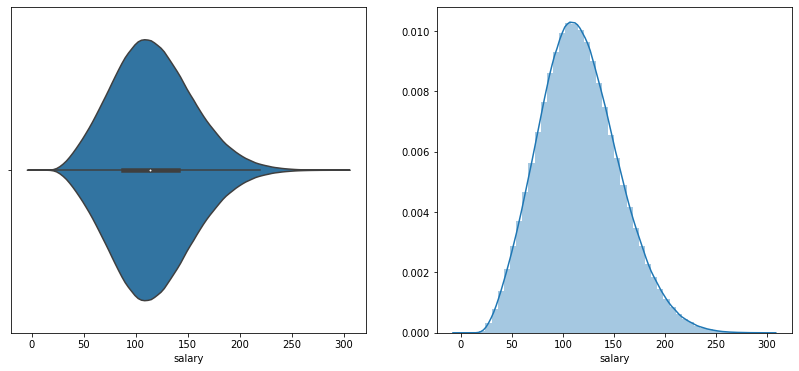

In [23]:
# visual of salary data distribution

plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.violinplot(train_df.salary)
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins = 50)
plt.show()

Our visuals show a fairly uniform salary distribution with a right-skew, which seems normal when you mix senior level positions with middle-management and junior level positions. Let's look closer at potential outliers.

In [24]:
stats = train_df.salary.describe()

print(stats)

IQR = stats['75%'] - stats['25%']

upper = stats['75%'] + 1.5 * IQR

lower = stats['25%'] - 1.5 * IQR

print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


Let's take a closer look at the suspected outliers.

In [25]:
#check potential outlier below lower bound

train_df[train_df.salary < 8.5].count()

jobId                  5
companyId              5
jobType                5
degree                 5
major                  5
industry               5
yearsExperience        5
milesFromMetropolis    5
salary                 5
dtype: int64

In [26]:
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


At the low end of the salary scale it looks like we simply have data that was not entered or was unknown. It's doubtful any of these people are working for free. We'll remove these rows from our dataset.

In [27]:
# Remove data with zero salaries

train_df = train_df[train_df.salary > 8.5]
train_df.shape

(999995, 9)

In [28]:
#check potential outlier above upper bound
train_df.loc[train_df.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

Not surprising that senior-level, and above, positions have potential outlier salaries. The more curious cases are the JUNIOR positions with these salaries. Let's take a look at them. 

In [29]:
# Check most suspicious potential outliers above upper bound

train_df[(train_df.salary > 222.5) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,JOB1362684908426,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,JOB1362685035221,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,JOB1362685053242,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


High salaries for these JUNIOR job types looks reasonable. Most of the positions are in Oil and Finance, where compensation can be above-average. Additionally, most have 20 years, or more, of experience, which typically coorelates to higher salaries. 

There's no compelling reason to exclude any of the potential outlier salaries at the upper end of the distribution, so we'll run with this data set to train our models.

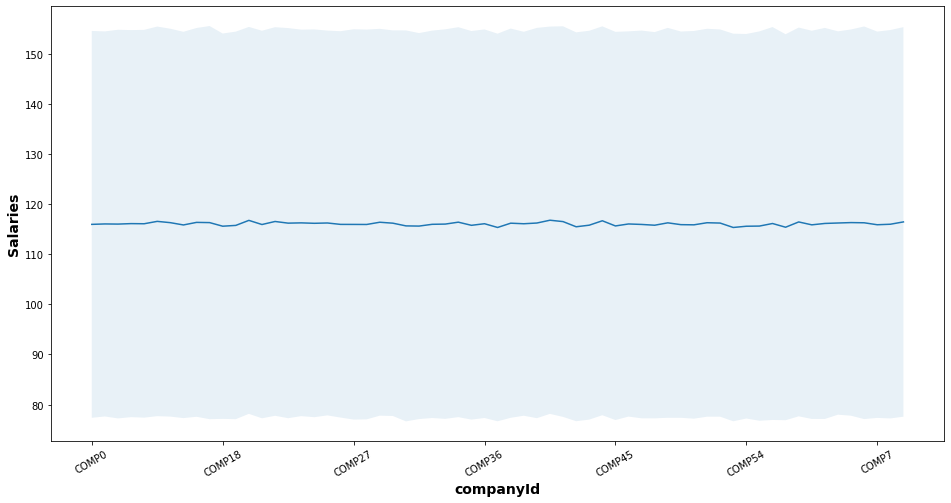

In [30]:
feature_viz(train_df, 'companyId')

**Looks like salary has little-to-no correlation with company.**

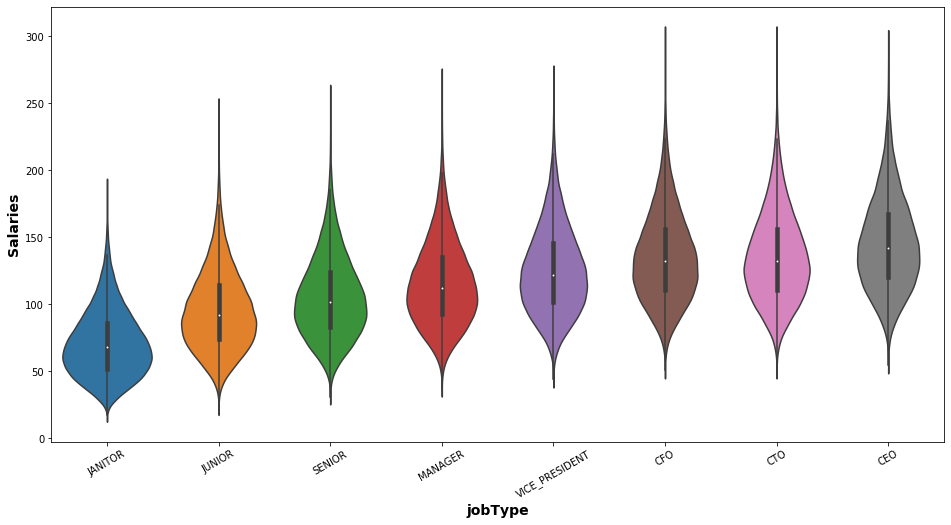

In [31]:
feature_viz(train_df, 'jobType')

**Salary is clearly correlated with type of job.**

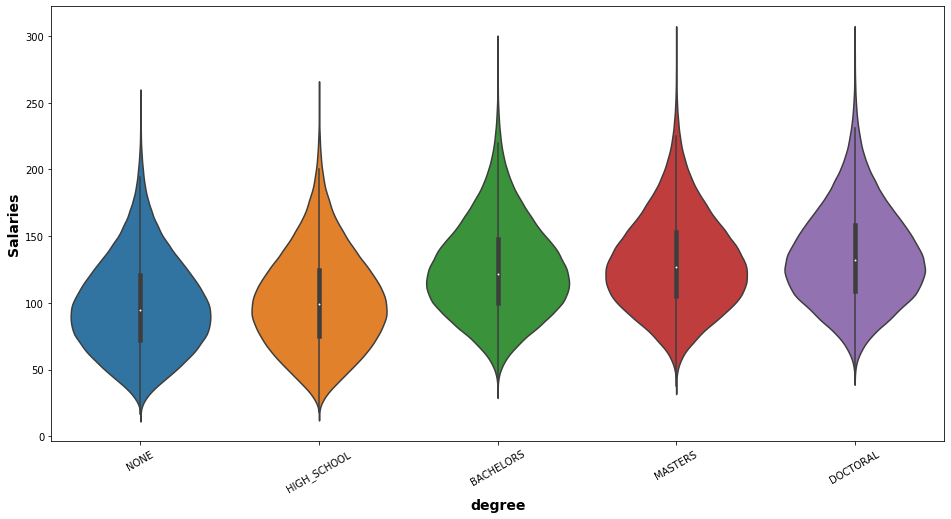

In [32]:
feature_viz(train_df, 'degree')

**The more education the more likely you are to have a higher salary.**

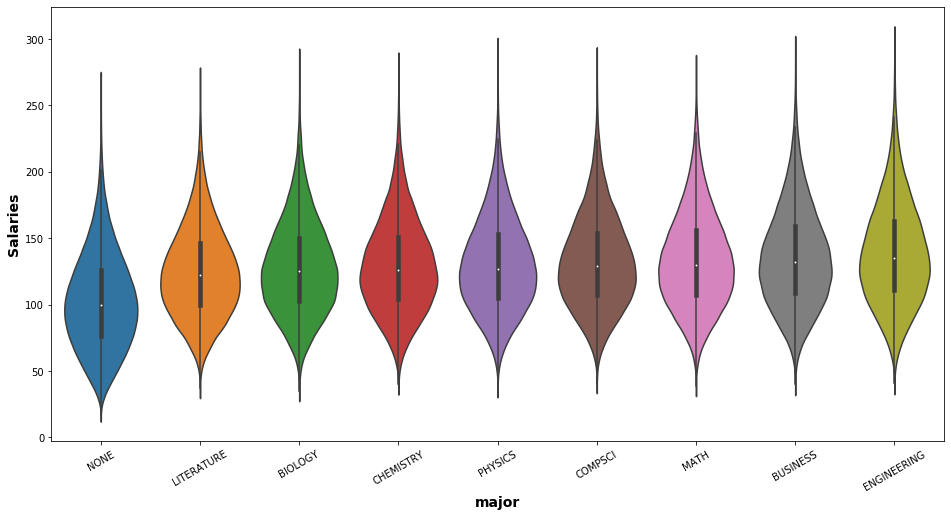

In [33]:
feature_viz(train_df, 'major')

**Choice of major seems to have a slight correlation with salary.**

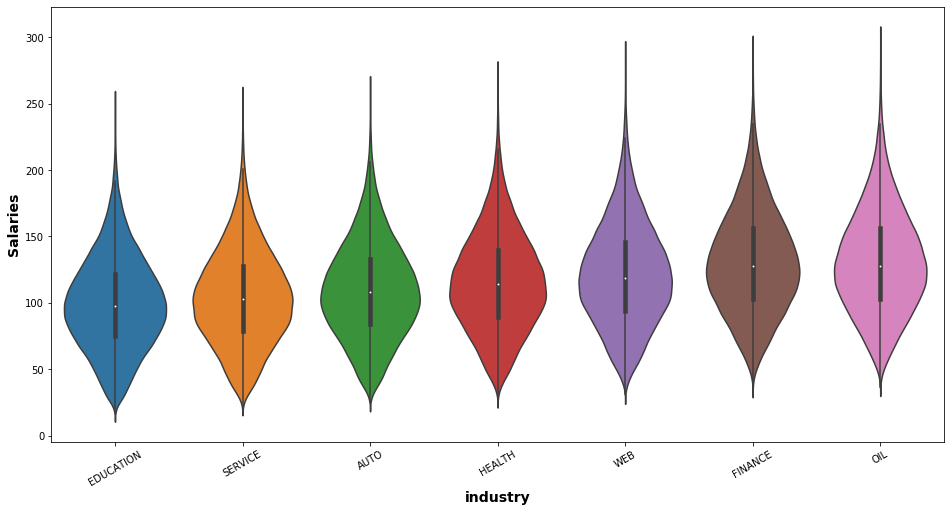

In [34]:
feature_viz(train_df, 'industry')

**Choice of industry appears to influence salary level.**

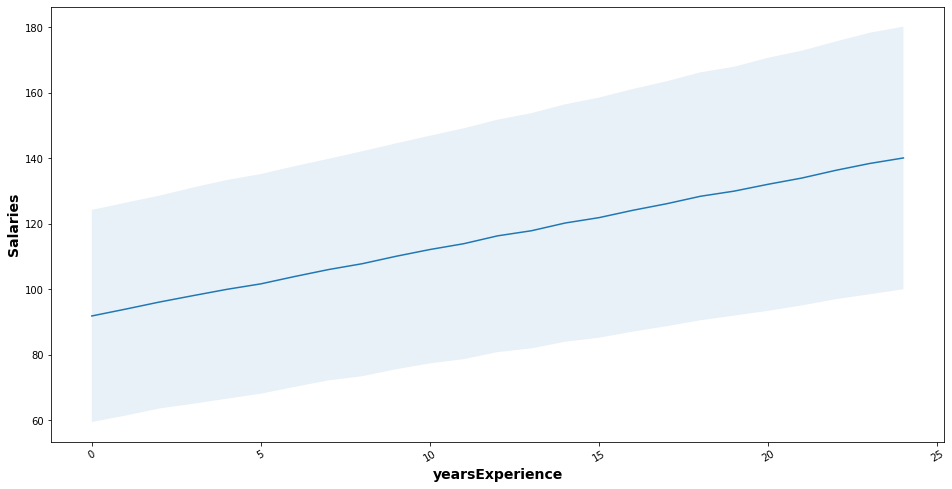

In [35]:
feature_viz(train_df, 'yearsExperience')

**Years of expeience looks to strongly influence salary level.**

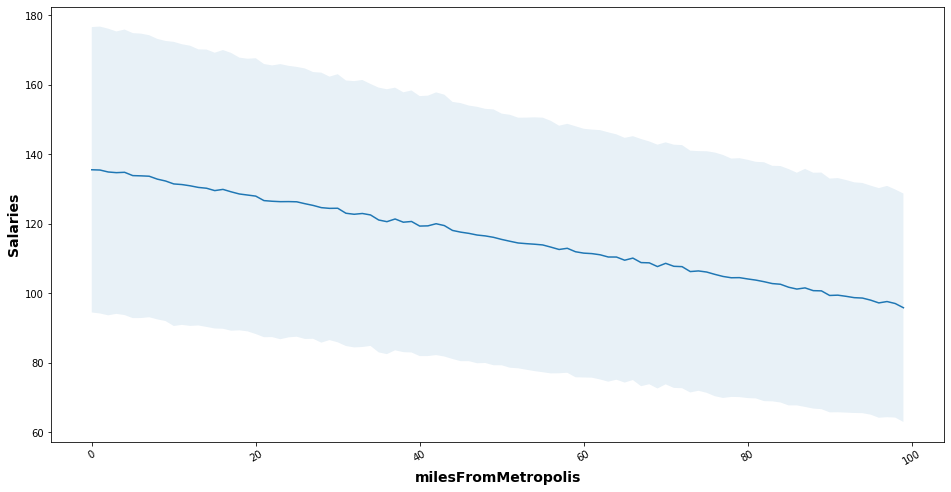

In [36]:
feature_viz(train_df, 'milesFromMetropolis')

**Distance from a metropolis shows an inverse correlation relationship with salary, i.e. the further you live from a metropolis the more like it is that your salary is lower.**

### ---- 5 Establish a baseline ----

Before we build more complex models, let's start with a baseline metric. We'll compare our other models to the baseline to show how much they improve over the baseline. A common metric for making salary comparisons is the average industry salary, so we'll start with this.

In [37]:
baseline_df = train_df.groupby('industry', as_index = False).mean()
baseline_df.rename(columns = {'salary':'avg_salary'}, inplace = True)
baseline_df = baseline_df[['industry', 'avg_salary']]
baseline_df

,industry,avg_salary
0,EDUCATION,99.448386
1,SERVICE,104.446820
2,AUTO,109.435222
3,HEALTH,115.735540
4,WEB,121.645362
5,FINANCE,130.747659
6,OIL,130.953863


In [38]:
baseline_df = pd.merge(train_df, baseline_df, on = 'industry')
baseline_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,avg_salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,115.73554
1,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,115.73554
2,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178,115.73554
3,JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NONE,HEALTH,24,30,102,115.73554
4,JOB1362684407709,COMP30,JUNIOR,BACHELORS,LITERATURE,HEALTH,18,69,105,115.73554
5,JOB1362684407710,COMP38,JUNIOR,NONE,NONE,HEALTH,20,63,76,115.73554
6,JOB1362684407717,COMP49,JUNIOR,BACHELORS,PHYSICS,HEALTH,23,2,159,115.73554
7,JOB1362684407718,COMP0,CFO,BACHELORS,PHYSICS,HEALTH,18,32,132,115.73554
8,JOB1362684407720,COMP36,JUNIOR,MASTERS,MATH,HEALTH,12,78,100,115.73554
9,JOB1362684407721,COMP31,MANAGER,DOCTORAL,NONE,HEALTH,15,14,164,115.73554


In [39]:
from sklearn.metrics import mean_squared_error

print('The mean squared error of the industry average salary is: ' + str(mean_squared_error(baseline_df['salary'], baseline_df['avg_salary'])))


The mean squared error of the industry average salary is: 1367.1229507852554


Lots of HR departments make salary decisions based on the median or mean salary of an industry or profession. We'll use the MSE of 1367 for the average salaries compared to the actually salaries as our baseline. Our goal is to lower the MSE below 360 with at least one of our models.

### ---- 6 Hypothesize solution ----

The suite of regression supervised learning algorithms comes to mind since we have a large sample set of data. We'll create Linear Regression and Decision Tree models for speed. For more accurate models we'll create Random Forest and Gradient Boost models.

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [40]:
cat_var = ['companyId', 'jobType', 'degree', 'major', 'industry']

target_var = ['salary']

In [41]:
# one hot encode categorical features

cat_df = pd.get_dummies(train_df[cat_var])
num_df = train_df[num_var].apply(pd.to_numeric)

# merge categorials and numeric features

model_df = pd.concat([cat_df, num_df], axis = 1)
model_df

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_ENGINEERING,industry_EDUCATION,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10,83
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3,73
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10,38
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,8,17
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,19,94
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,12,35
999997,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,16,81
999998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,6,5


In [43]:
target_df = train_df[target_var]
target_df

,salary
0,130
1,101
2,137
3,142
4,163
...,...
999995,88
999996,160
999997,64
999998,149


In [44]:
test_cat_df = pd.get_dummies(test_df[cat_var])
test_num_df = test_df[num_var].apply(pd.to_numeric)
test_df = pd.concat([test_cat_df, test_num_df], axis = 1)

test_df

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,22,73
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,20,47
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,96
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,3
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,20,67
999997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,91
999998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,63


### ---- 8 Create/Test models and select best model ----

Before creating the actual models I'll define functions to loop through the model testing.

In [45]:
def train_model(model, model_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, model_df, target_df, cv = 2, n_jobs = num_procs, scoring = 'neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

Now we'll instantiate an instance of each model and create the variables to save the results and select the model with lowest mean squared error.

In [47]:
# initialize models list and dicts

models = []
mean_mse = {}
cv_std = {}

# define number of processes to run in parallel

num_procs = 4

# create models -- hyperparameter tuning already done by hand for each model

lr = LinearRegression()

dtr = DecisionTreeRegressor(max_depth = 15)
    
rf = RandomForestRegressor(n_estimators = 50, n_jobs = num_procs, max_depth = 25, min_samples_split = 60, \
                               max_features = 30)

gbm = GradientBoostingRegressor(n_estimators = 50, max_depth = 10)    

models.extend([lr, dtr, rf, gbm])

# parallel cross-validate models, using MSE as evaluation metric, and print summaries

print("Starting cross validation")

for model in models:
        
    train_model(model, model_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

# select model with lowest mse

model = min(mean_mse, key=mean_mse.get)

print('\nModel with lowest MSE to use for predictions:')

print(model)

Starting cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4948480094814
Standard deviation during CV:
 1.3977688555859515

Model:
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=15,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Average MSE:
 416.0904628058005
Standard deviation during CV:
 1.3853843237059777

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

Now that we have the most effective model we'll train it on the entire dataset and generate predictions on our test dataset.

In [52]:
# train model on entire dataset

model.fit(model_df, target_df)

# create predictions based on test data
predictions = model.predict(test_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
predictions = pd.DataFrame(data = predictions)
predictions.info

<bound method DataFrame.info of                  0
0       144.581657
1       140.649854
2       135.311003
3       128.167686
4       119.291455
...            ...
999995  181.872859
999996  155.174588
999997  107.017217
999998  121.907124
999999  158.757474

[1000000 rows x 1 columns]>

Finally we'll identify the feature importances, visualize them in a bar plot and save the results.

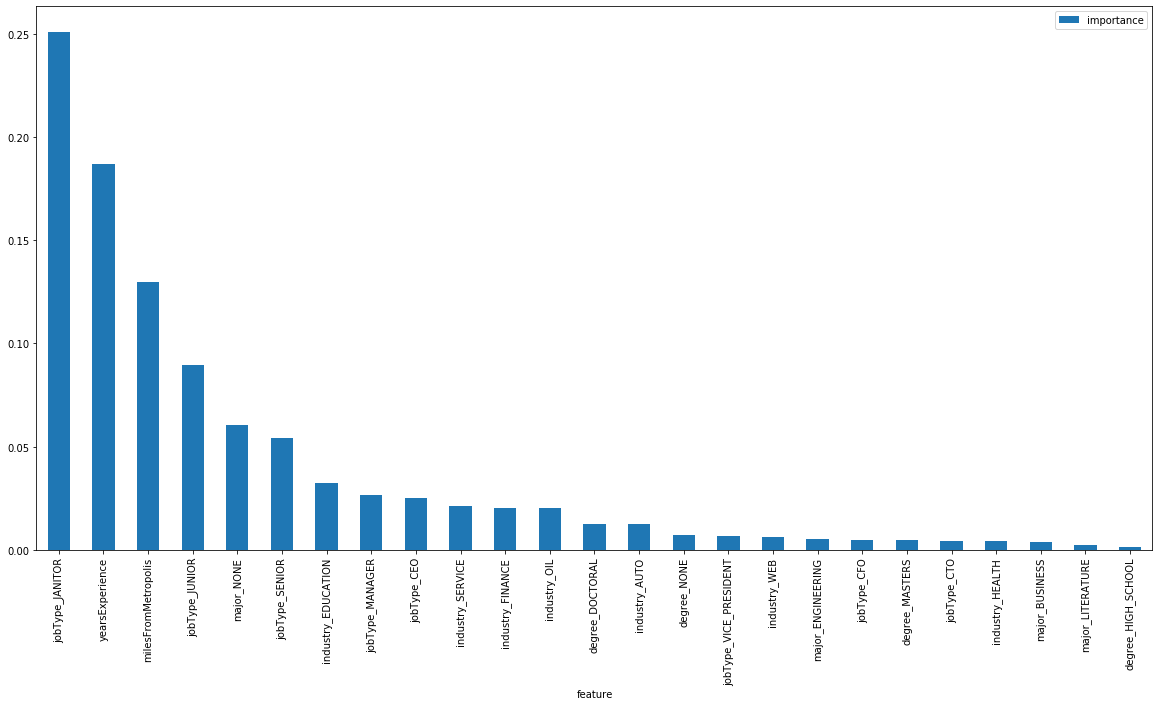

In [55]:
# store feature importances

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_

else:
    # for linear models which don't have feature_importances_
    importances = [0]*len(model_df.columns)

feature_importances = pd.DataFrame({'feature':model_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
# set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
# create plot
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

### ---- 12 Deploy solution ----

In [56]:
predictions.to_csv(r'Data\salary_predictions.csv')